https://www.kaggle.com/competitions/tutors-expected-math-exam-results

Регрессия

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# Метод для нормализации данных

def centered(data, means=None, std=None):
    X_ = data.astype(float)
    rows, cols = X_.shape

    if means is None:
        means = X_.mean(axis=0)
    
    if std is None:
        std = np.std(X_, axis=0)
    
    for j in range(cols):
        for i in range(rows):
            X_[i, j] = (X_[i, j] - means[j]) / std[j]
    
    return X_, means, std

In [29]:
rng = np.random.default_rng(seed=42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    full_indices = range(n_samples)
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        b_indices = set()  # сохраняем индексы, используемые для дерева
        
        for j in full_indices:
            sample_index = rng.integers(0, high=n_samples-1, size=1)[0]
            b_indices.add(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            
        # сохраняем не вошедшие в bootstrap индексы для OOB метода
        bootstrap.append((b_data, b_labels, np.setdiff1d(full_indices, list(b_indices))))
    return bootstrap

In [30]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    rng.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [31]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [32]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        return np.mean(self.labels) 

In [33]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * np.var(left_labels) - (1 - p) * np.var(right_labels)

In [34]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [35]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = np.var(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объекта
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [36]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [37]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels, b_OOB in bootstrap:
        forest.append((build_tree(b_data, b_labels), b_OOB))
        
    return forest

In [38]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf): 
        answer = node.prediction
        return answer
    
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [39]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [40]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree, b_oob in forest:
            predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(np.mean(obj))
        
    return voted_predictions

In [41]:
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)
    return err

In [58]:
def OOB_error(forest, data, labels):
    oob_pred, oob_actual = [], []
    n_samples = data.shape[0]
    for i in range(n_samples):
        predictions = []
        for tree, OOB_inds in forest:
            if i in OOB_inds:  # если объект не участвовал в обучении дерева
                predictions.append(classify_object(data[i], tree))
        
        if len(predictions) > 0:  # если объект попал в общую Out-of-bag выборку
            oob_pred.append(np.mean(predictions))
            oob_actual.append(labels[i])
    
    return calc_mse(np.array(oob_actual), oob_pred), len(oob_pred)

Работа с данными из датасета

In [43]:
train_df = pd.read_csv("train.csv")
train_df.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


In [44]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


In [45]:
train_df.drop(['Id'], axis=1, inplace=True)
train_df.describe()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,45.878000,1.986800,1699.105000,1.719500,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,64.340800
std,8.043929,1.772213,524.886654,0.792264,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,13.536823
min,23.000000,0.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,40.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000
50%,46.000000,2.000000,1500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
max,68.000000,10.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


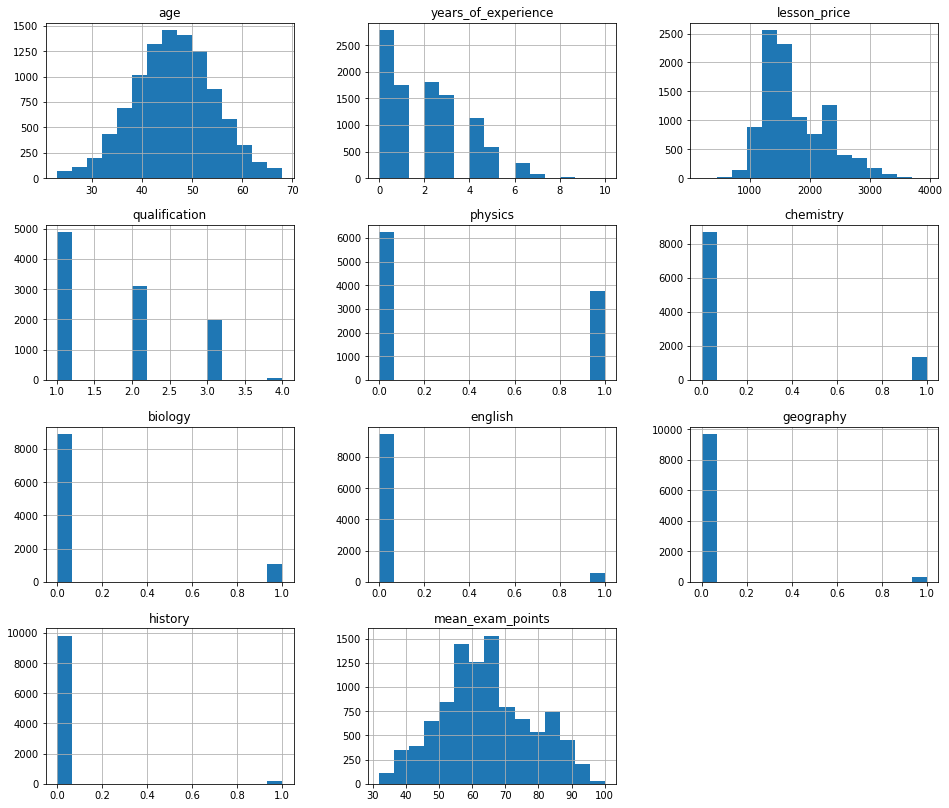

In [46]:
train_df.hist(figsize =(16,14),bins = 15, grid = True)
plt.show()

In [60]:
target_name = 'mean_exam_points'
train_labels = train_df[target_name].to_numpy()

In [61]:
train_data, m, s = centered(train_df.drop(columns=target_name).to_numpy())

forest = random_forest(train_data, train_labels, 25)
train_answers = tree_vote(forest, train_data)
train_mse = calc_mse(train_labels, train_answers)
oob_error = OOB_error(forest, train_data, train_labels)
train_mse, oob_error

(27.16934488119219, (43.681939678359534, 10000))

In [62]:
test_df = pd.read_csv("test.csv")
test_data = centered(test_df.drop(columns='Id').to_numpy(), means=m, std=s)[0]
test_answers = tree_vote(forest, test_data)

In [63]:
preds_final = pd.DataFrame()
preds_final['Id'] = test_df['Id'].copy()
preds_final['mean_exam_points'] = test_answers
preds_final.to_csv('./predictions.csv', index=False, encoding='utf-8', sep=',')

preds_final.head()

,Id,mean_exam_points
0,10000,55.327235
1,10001,62.735837
2,10002,49.121016
3,10003,88.473944
4,10004,88.647258
